In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [100]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer

In [101]:
boston_housing_data = load_boston()
X = pd.DataFrame(boston_housing_data['data'], columns=boston_housing_data['feature_names'])
y = boston_housing_data['target']

In [105]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [103]:
scaler = StandardScaler()

In [104]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### LASSO-регрессия a.k.a. L1-регуляризация
$$ \sum_{i=0}^N{(y_i - \hat{y}_i)^2 + \alpha |\hat{\beta}_i}| \rightarrow min $$


In [106]:
regr = Lasso(alpha=0.5)

In [107]:
regr.fit(X_train_scaled, y_train)

Lasso(alpha=0.5)

In [108]:
mean_squared_error(y_test, regr.predict(X_test_scaled))

25.343992307954146

In [109]:
cv = KFold(n_splits=5, shuffle=True)

cross_val_score(regr, X_train_scaled, y_train, cv=cv, scoring=make_scorer(mean_squared_error))

array([46.79686204, 27.35391155, 25.58517039, 17.3881826 , 24.34419218])

In [75]:
params = {
    'alpha': np.linspace(0.25, 0.75, 10)
}

gs = GridSearchCV(regr, params, scoring='neg_mean_squared_error', cv=cv)

In [76]:
gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Lasso(alpha=0.5),
             param_grid={'alpha': array([0.25      , 0.30555556, 0.36111111, 0.41666667, 0.47222222,
       0.52777778, 0.58333333, 0.63888889, 0.69444444, 0.75      ])},
             scoring='neg_mean_squared_error')

In [77]:
gs.best_params_

{'alpha': 0.25}

In [78]:
model = Pipeline([
    ('scale', StandardScaler()),
    ('regr', Lasso(alpha=0.25)),
])

In [79]:
model.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()), ('regr', Lasso(alpha=0.25))])

In [80]:
mean_squared_error(y_test, model.predict(X_test))

24.266414133741236

<img src="../pics/lasso_vs_ridge_regression.png" style="width:100%" align = "center"/>


### Elastic Net regression

$$ \sum_{i=0}^N{(y_i - \hat{y}_i)^2 + \alpha |\hat{\beta}_i}| + \alpha \hat{\beta}_i^2 \rightarrow min $$


In [111]:
from sklearn.linear_model import ElasticNet

In [112]:
ElasticNet()

ElasticNet()

### Полиномиальная регрессия

In [113]:
n = 100

x = 8 * np.random.rand(100)
y = np.cos(x) + 0.1234 * np.random.randn(100)

#Create single dimension
x= x[:,np.newaxis]
y= y[:,np.newaxis]

inds = x.ravel().argsort()
x = x.ravel()[inds].reshape(-1,1)
y = y[inds]

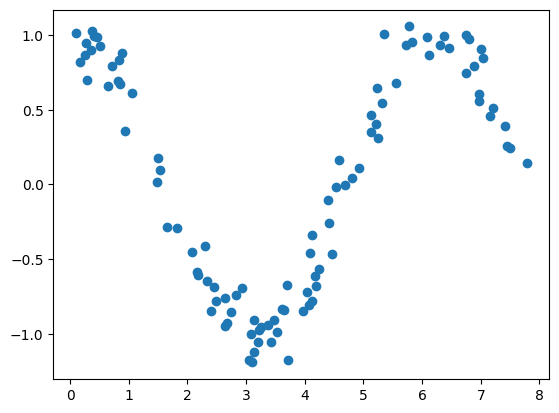

In [114]:
plt.scatter(x,y)

Text(0, 0.5, 'x')

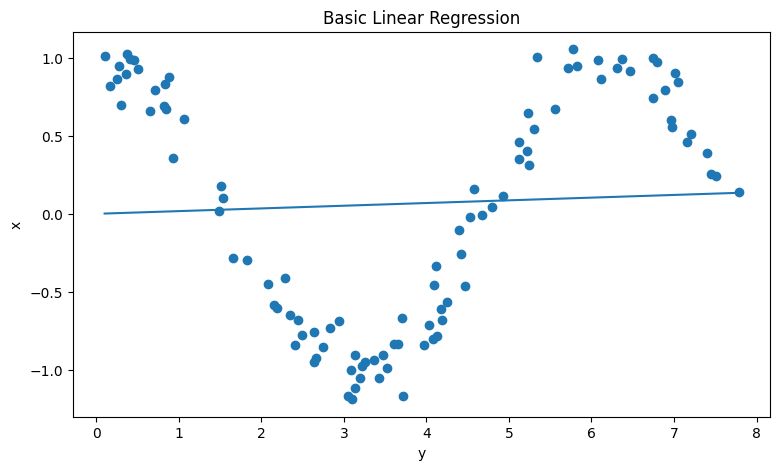

In [115]:
model = sm.OLS(y, x).fit()
ypred = model.predict(x) 

fig, ax = plt.subplots(figsize=(9, 5))
ax.scatter(x, y)
ax.plot(x,ypred)
ax.set_title('Basic Linear Regression')
ax.set_xlabel('y')
ax.set_ylabel('x')

$$ y = b_0+b_1x+b_2x^2+b_3x^3 $$

In [116]:
from sklearn.preprocessing import PolynomialFeatures

In [135]:
polynomial_features= PolynomialFeatures(degree=5)
x_plus_pol = polynomial_features.fit_transform(x)

In [136]:
x_plus_pol.shape

(100, 6)

Text(0, 0.5, 'y')

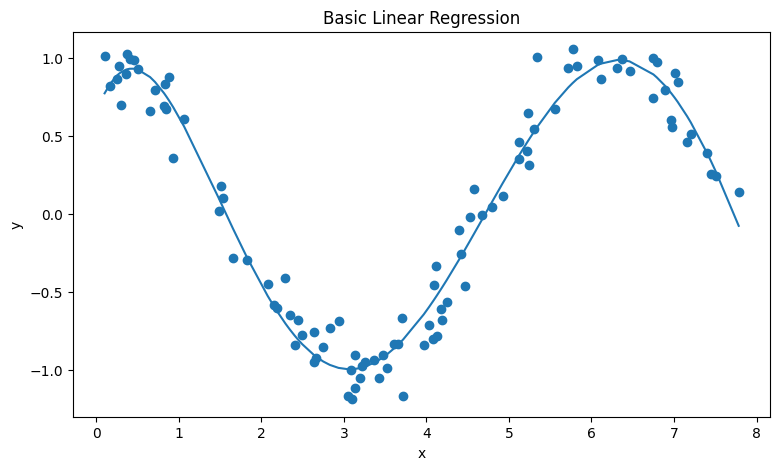

In [138]:
model = sm.OLS(y, x_plus_pol).fit()
ypred = model.predict(x_plus_pol) 

fig, ax = plt.subplots(figsize=(9, 5))
ax.scatter(x, y)
ax.plot(x,ypred)
ax.set_title('Basic Linear Regression')
ax.set_xlabel('x')
ax.set_ylabel('y')

### StepWise

In [26]:
from sklearn.datasets import make_regression

In [157]:
X, y = make_regression(
    n_samples=1000, 
    n_features=100, 
    n_informative=20,
    random_state=42, 
    bias=12.55, noise=15.5
)

In [158]:
class StepwiseRegression:
    def __init__(self, strategy, eps):
        assert strategy in ('forward', 'backward'), 'Invalid regression strategy'
        self.strategy = strategy 
        self.fit = self._forward_fit if self.strategy == 'forward' else self._backward_fit
        self.eps = eps
        
    @staticmethod
    def _test_sample(X, y):
        model = sm.OLS(endog=y, exog=sm.add_constant(X), hasconst=True).fit()
        return model.rsquared_adj
    
    def _forward_fit(self, X, y):
        best_score = 0
        selected_features = []
        selected_feature_number = -1
        while True:
            for feature_number in set(range(X.shape[1])) - set(selected_features):
                score_selected = self._test_sample(X[:, selected_features+[feature_number]], y)
                if score_selected - best_score > self.eps:
                    best_score = score_selected
                    selected_feature_number = feature_number
            if selected_feature_number == -1:
                break
            
            selected_features.append(selected_feature_number)
            print(f'Selected feature {selected_feature_number}')
            selected_feature_number = -1
            
        self.selected_ = selected_features
        self.best_score_ = best_score
                
    
    def _backward_fit(self, X, y):
        best_score = self._test_sample(X, y)
        selected_features = list(range(X.shape[1]))
        excluded_feature_number = -1
        while True:
            for feature_number in selected_features:
                score_excluded = self._test_sample(np.delete(X, feature_number, axis=1), y)
                if score_excluded >= best_score:
                    best_score = score_excluded
                    excluded_feature_number = feature_number
            if excluded_feature_number == -1:
                break
            
            selected_features.remove(excluded_feature_number)
            print(f'Excluded feature {excluded_feature_number}')
            excluded_feature_number = -1
            
        self.selected_ = selected_features
        self.best_score_ = best_score
    

In [161]:
swr = StepwiseRegression('forward', eps=0.01)

In [162]:
swr.fit(X, y)

Selected feature 35
Selected feature 58
Selected feature 88
Selected feature 31
Selected feature 46
Selected feature 83
Selected feature 82
Selected feature 93
Selected feature 24
Selected feature 49
Selected feature 9
Selected feature 29
Selected feature 76
Selected feature 90


In [153]:
swr.selected_

[5, 2, 3, 7, 1]

In [154]:
swr.best_score_

0.9487831937823372

### Боремся с гетероскедастичностью

Предположим, что условие  
"Дисперсия ошибок одинакова и равна некоторой $\sigma ^{2}$"  
не выполняется, то есть 
$$ \mathrm{D}(\varepsilon_i|x_i) = f(x_i) \neq \sigma ^{2} $$

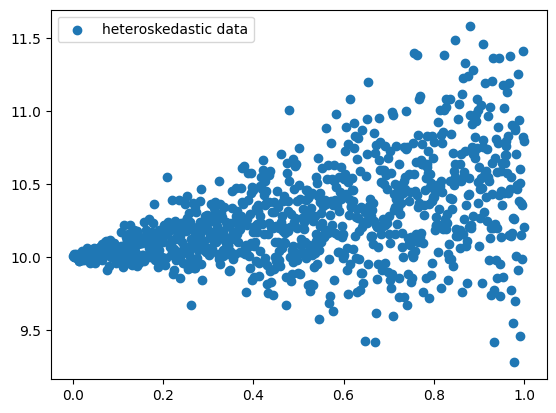

In [163]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.RandomState(42)
x = np.linspace(start=0.001, stop=1, num=1000)
X = x[:, np.newaxis]
y_true_mean = 10 + 0.5 * x
y_heteroskedastic = y_true_mean + rng.normal(loc=0, scale=0.01 + 0.5 * x, size=x.shape[0])

plt.scatter(X, y_heteroskedastic, label='heteroskedastic data')
plt.legend()
plt.show()

In [164]:
model = sm.OLS(endog=y_heteroskedastic, exog=sm.add_constant(X), hasconst=True).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     292.2
Date:                Thu, 02 Nov 2023   Prob (F-statistic):           1.20e-57
Time:                        22:15:07   Log-Likelihood:                -184.77
No. Observations:                1000   AIC:                             373.5
Df Residuals:                     998   BIC:                             383.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9872      0.018    541.564      0.000       9.951      10.023
x1             0.5456      0.032     17.092      0.000       0.483       0.608
==============================================================================
Omnibus:                       47.235   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.486
Skew:                           0.084   Prob(JB):                     1.55e-32
Kurtosis:                       4.867   Cond. No.                         4.39
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

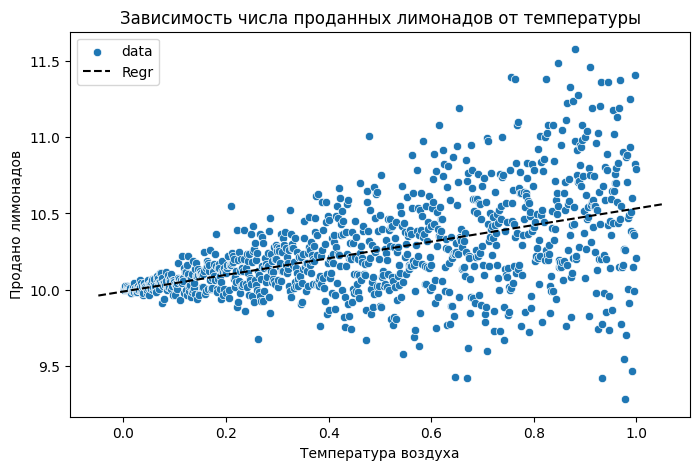

In [165]:
def abline(ax, slope, intercept):
    """Plot a line from slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--', color='black', label='Regr')
    
    
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title('Зависимость числа проданных лимонадов от температуры')
ax.set_xlabel('Температура воздуха')
ax.set_ylabel('Продано лимонадов')
sns.scatterplot(x=X[:, 0], y=y_heteroskedastic, marker='o', ax=ax, label='data')
abline(ax, model.params[1], model.params[0])
ax.legend()

### WLS. Аналитическое решение
$$\hat{\beta} = (X^TWX)^{-1}X^TWy$$

In [167]:
model = sm.WLS(endog=y_heteroskedastic, exog=sm.add_constant(X), weights=1/X[:, 0], hasconst=True).fit()

In [168]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.433
Model:                            WLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     762.3
Date:                Thu, 02 Nov 2023   Prob (F-statistic):          3.98e-125
Time:                        22:17:36   Log-Likelihood:                 96.535
No. Observations:                1000   AIC:                            -189.1
Df Residuals:                     998   BIC:                            -179.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9993      0.005   2047.313      0.000       9.990      10.009
x1             0.5215      0.019     27.610      0.000       0.484       0.559
==============================================================================
Omnibus:                       13.605   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.648
Skew:                           0.122   Prob(JB):                     5.41e-05
Kurtosis:                       3.642   Cond. No.                         4.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

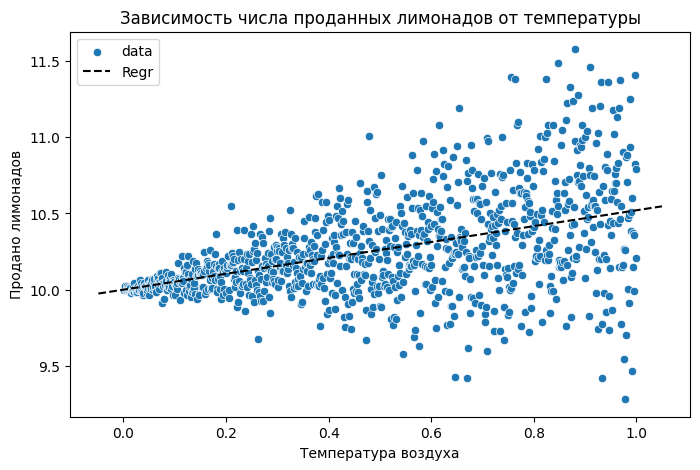

In [169]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title('Зависимость числа проданных лимонадов от температуры')
ax.set_xlabel('Температура воздуха')
ax.set_ylabel('Продано лимонадов')
sns.scatterplot(x=X[:, 0], y=y_heteroskedastic, marker='o', ax=ax, label='data')
abline(ax, model.params[1], model.params[0])
ax.legend()

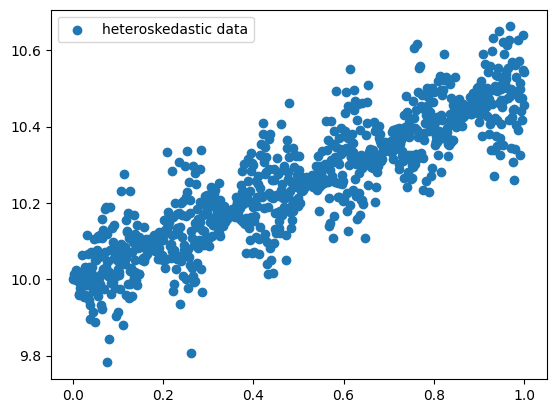

In [170]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.RandomState(42)
x = np.linspace(start=0.001, stop=1, num=1000)
X = x[:, np.newaxis]
y_true_mean = 10 + 0.5 * x
y_heteroskedastic = y_true_mean + rng.normal(loc=0, scale=np.abs(np.sin(x*18))/10, size=x.shape[0])

plt.scatter(X, y_heteroskedastic, label='heteroskedastic data')
plt.legend()
plt.show()

In [171]:
model = sm.WLS(endog=y_heteroskedastic, exog=sm.add_constant(X), weights=1/np.sin(X[:, 0]), hasconst=True).fit()

In [172]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.835
Model:                            WLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     5050.
Date:                Thu, 02 Nov 2023   Prob (F-statistic):               0.00
Time:                        22:19:20   Log-Likelihood:                 1055.9
No. Observations:                1000   AIC:                            -2108.
Df Residuals:                     998   BIC:                            -2098.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9971      0.002   5206.109      0.000       9.993      10.001
x1             0.5084      0.007     71.064      0.000       0.494       0.522
==============================================================================
Omnibus:                      130.663   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1140.298
Skew:                          -0.240   Prob(JB):                    2.44e-248
Kurtosis:                       8.209   Cond. No.                         4.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

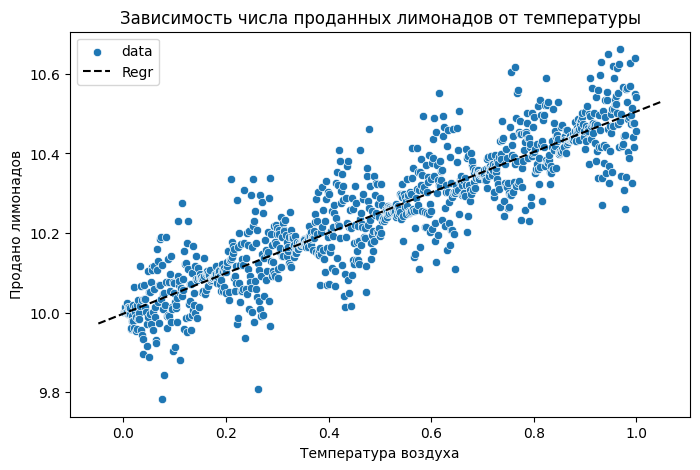

In [173]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title('Зависимость числа проданных лимонадов от температуры')
ax.set_xlabel('Температура воздуха')
ax.set_ylabel('Продано лимонадов')
sns.scatterplot(x=X[:, 0], y=y_heteroskedastic, marker='o', ax=ax, label='data')
abline(ax, model.params[1], model.params[0])
ax.legend()

### LAR (LAD)

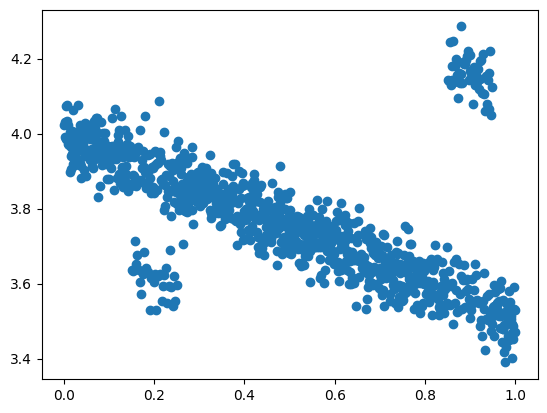

In [174]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.RandomState(42)
x = np.linspace(start=0.001, stop=1, num=1000)
X = x[:, np.newaxis]
y = (4 - 0.5 * x) + rng.normal(loc=0, scale=0.05, size=x.shape[0])
y[850:950:2] += 0.6
y[150:250:3] -= 0.3


plt.scatter(X, y)
plt.show()

In [175]:
model = sm.OLS(endog=y, exog=sm.add_constant(X), hasconst=True).fit()

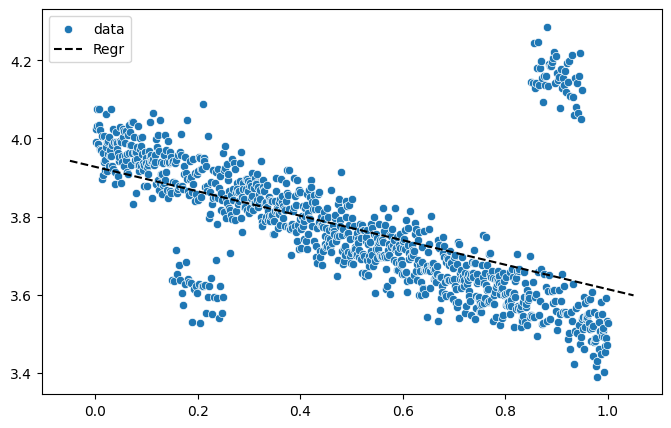

In [176]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(x=X[:, 0], y=y, marker='o', ax=ax, label='data')
abline(ax, model.params[1], model.params[0])
ax.legend()

<AxesSubplot: >

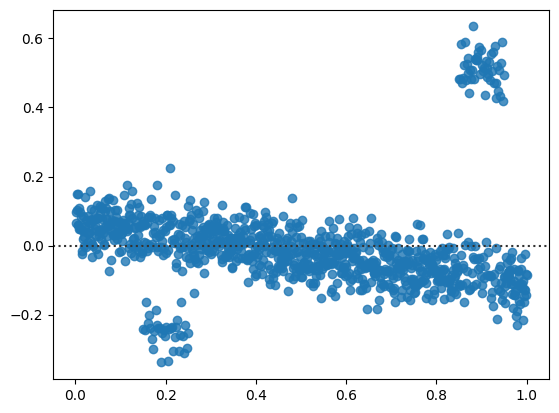

In [177]:
sns.residplot(x=X[:, 0], y=model.resid)

<AxesSubplot: ylabel='Density'>

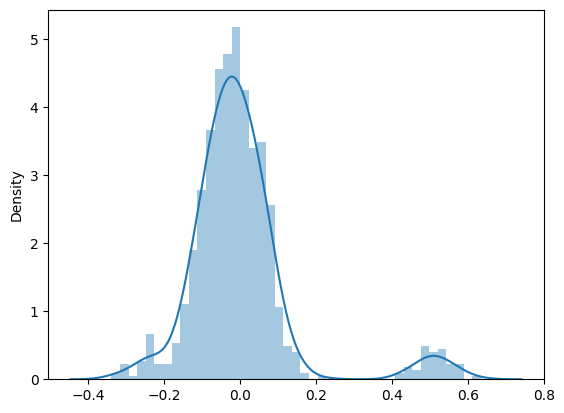

In [178]:
sns.distplot(model.resid)

$$ \sum_{i=0}^N{(y_i - \hat{y}_i)} \rightarrow min $$

$$ \sum_{i=0}^N{\left| y_i - \hat{y}_i \right|} \rightarrow min $$

$$ \frac{1}{N} \sum_{i=0}^N{\left| y_i - \hat{y}_i \right|} \rightarrow min $$

### IRLS

In [48]:
model = sm.OLS(endog=y, exog=sm.add_constant(X), hasconst=True).fit()

In [179]:
def get_robust_residuals(model, X):
    X1 = sm.add_constant(X)
    hats = np.diag(X1 @ np.linalg.inv(X1.T @ X1) @ X1.T)
    return (
        model.resid / ((np.median(np.abs(model.resid)) / 0.675) * np.sqrt(1-hats))
    )
    

In [180]:
def visualize(model, X):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.scatterplot(x=X[:, 0], y=y, marker='o', ax=axes[0], label='data')
    abline(axes[0], model.params[1], model.params[0])
    axes[0].legend()
    
    robust_standartizex_resid = get_robust_residuals(model, X)
    sns.residplot(x=X[:, 0], y=robust_standartizex_resid, ax=axes[1], label='robust resid')
    axes[1].legend()
    fig.show()

In [181]:
def get_weights(residual):
    if np.abs(residual) < 4.685:
        return (1 - ((residual/4.685) ** 2)) ** 2
    else:
        return 0
    
get_weights_vec = np.vectorize(get_weights)

In [182]:
def step(model, X, y):
    visualize(model, X)
    robust_standartized_resid = get_robust_residuals(model, X)
    w = get_weights_vec(robust_standartized_resid)
    model = sm.WLS(
        endog=y, 
        exog=sm.add_constant(X), 
        weights=w, 
        hasconst=True
    ).fit()
    return model

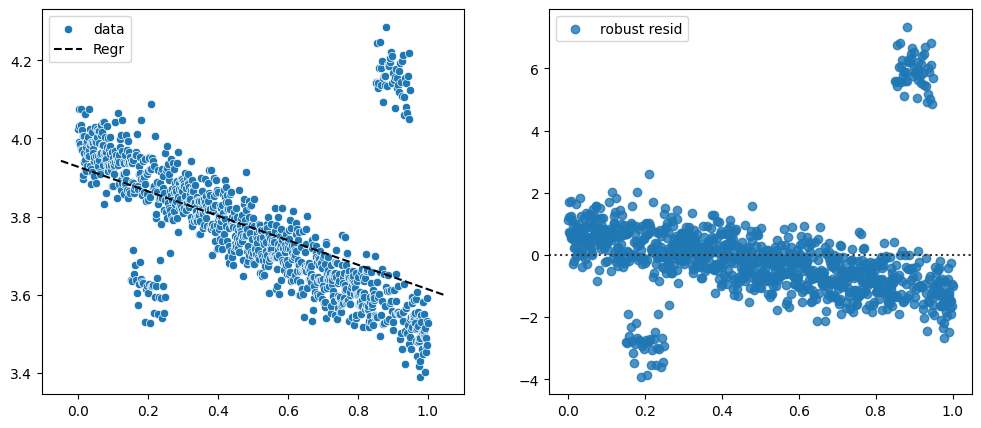

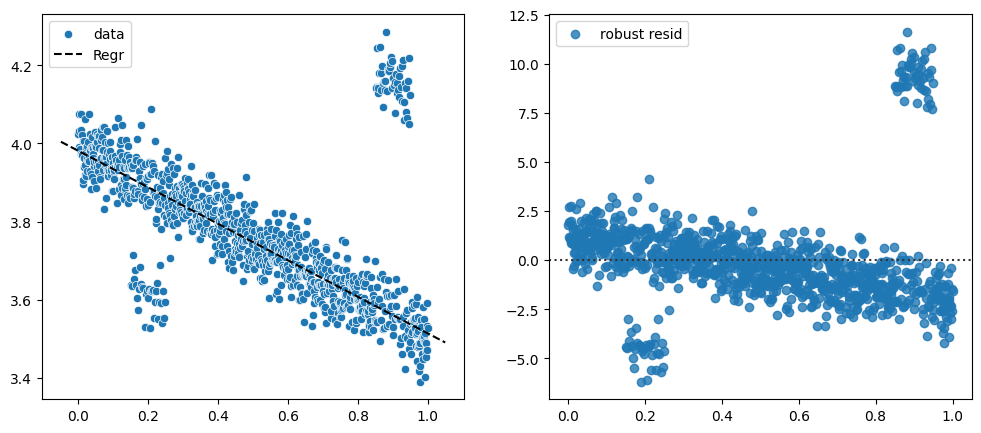

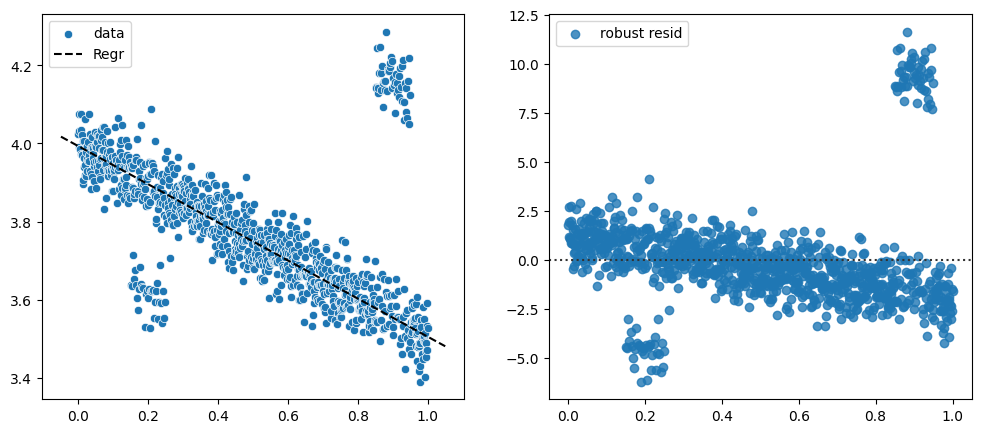

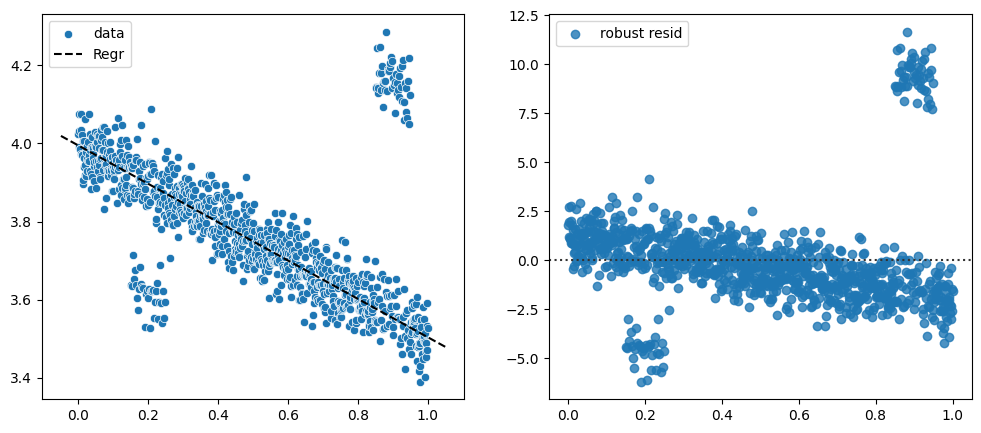

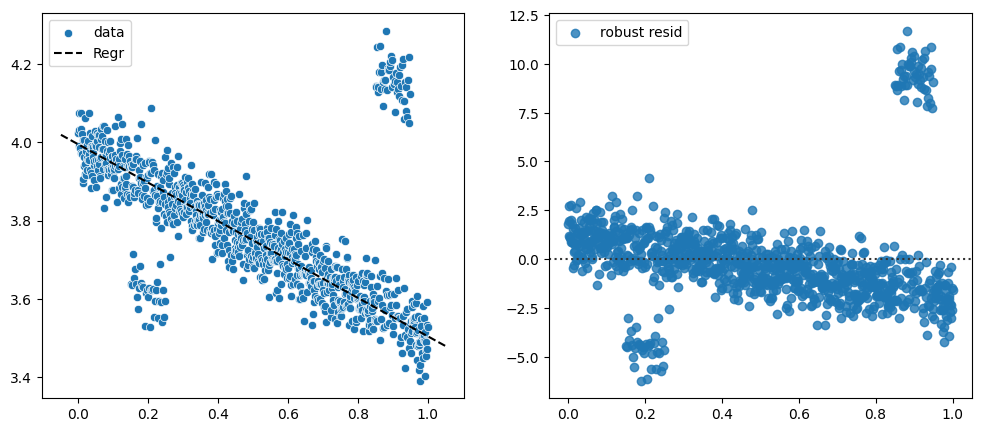

In [53]:
model = sm.OLS(endog=y, exog=sm.add_constant(X), hasconst=True).fit()

for _ in range(5):
    model = step(model, X, y)
    

### GLM

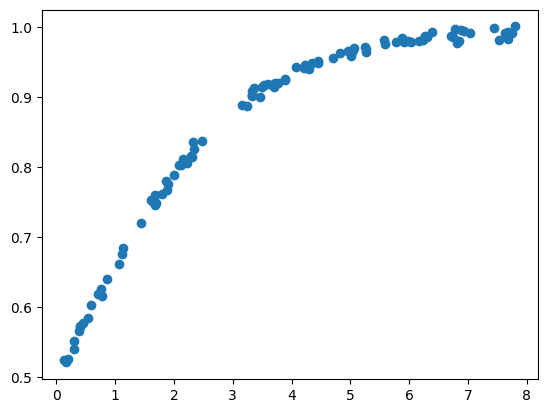

In [184]:
n = 100

x = 8 * np.random.rand(100)
y =  (1/(1+np.exp(-x/1.5))) + np.random.normal(0, 0.005, size=x.shape)

#Create single dimension
x= x[:,np.newaxis]
y= y[:,np.newaxis]

inds = x.ravel().argsort()
x = x.ravel()[inds].reshape(-1,1)
y = y[inds]

plt.scatter(x,y)

In [185]:
def logit(x):
    return np.log(x/(1-x))

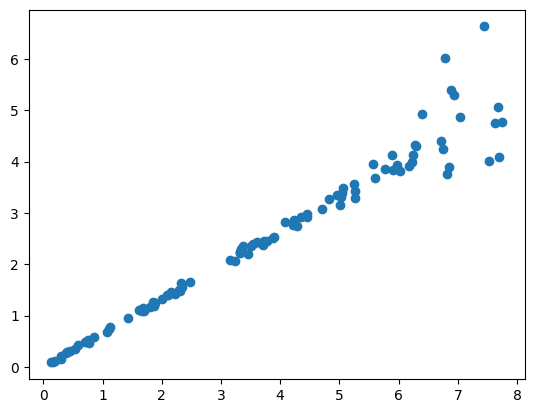

In [186]:
plt.scatter(x, logit(y))

In [187]:
model = sm.GLM(endog=y, exog=sm.add_constant(x), 
               family=sm.families.Binomial(link=sm.families.links.Logit())
              ).fit()

In [188]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -22.613
Date:                Thu, 02 Nov 2023   Deviance:                      0.18340
Time:                        22:33:36   Pearson chi2:                    0.110
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1559
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0071      0.495      0.014      0.989      -0.964       0.978
x1             0.6594      0.200      3.294      0.001       0.267       1.052
==============================================================================
"""

Text(0, 0.5, 'y')

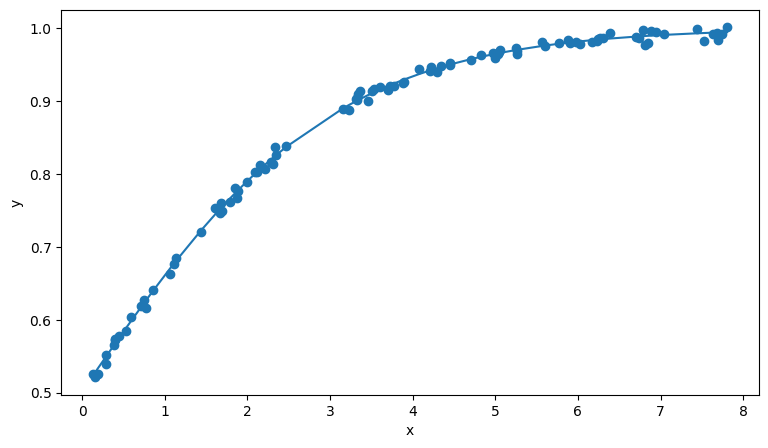

In [189]:
ypred = model.predict(sm.add_constant(x))

fig, ax = plt.subplots(figsize=(9, 5))
ax.scatter(x, y)
ax.plot(x,ypred)
ax.set_xlabel('x')
ax.set_ylabel('y')

In [190]:
model.predict(np.array([[1, 9999999]]))

array([1.])